In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

from typing import Tuple

torch.__version__

'1.6.0'

In [2]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [3]:
# from config import IR_CAMERA_RESOLUTION, TEMPERATURE_NORMALIZATION__MIN, TEMPERATURE_NORMALIZATION__MAX
IR_CAMERA_RESOLUTION_X = 32
IR_CAMERA_RESOLUTION_Y = 24

IR_CAMERA_RESOLUTION = (IR_CAMERA_RESOLUTION_Y, IR_CAMERA_RESOLUTION_X)

# for frames normalization
TEMPERATURE_NORMALIZATION__MIN = 20
TEMPERATURE_NORMALIZATION__MAX = 35

In [4]:
class ConvTranspose2dReplacement(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        super().__init__()
        # self.up = nn.Upsample(size=(2,2))
        self.up = nn.Upsample(scale_factor=stride)
        
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels, padding=padding, kernel_size=kernel_size)
        
    def forward(self, x) -> torch.Tensor:
        x = self.up(x)
        x = self.conv(x)
        return x
    

class AutoEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.conv = DoubleConv(32, 64, 3, 1)
        self.upconv1 = ExpandBlock(64, 32, 3, 1)
        self.upconv2 = ExpandBlock(32, 16, 3, 1)
        self.out_conv = nn.Conv2d(16, out_channels, kernel_size=1)
        
    def forward(self, x):
        # downsampling part
        x, conv2, conv1 = self.encoder(x)
        x = self.conv(x)
        x = self.upconv1(x, conv2)
        x = self.upconv2(x, conv1)
        x = self.out_conv(x)

        x = x[:, 0, :, :]  # get rid of one dimension
        return x


class ExpandBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int):
        super().__init__()
        #self.conv_transpose = nn.ConvTranspose2d(
        self.conv_transpose = ConvTranspose2dReplacement(
            in_channels=in_channels, out_channels=in_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x: torch.Tensor, encoder_features: torch.Tensor) -> torch.Tensor:
        x = self.conv_transpose(x)
        x = torch.cat((x, encoder_features), dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv1 = ContractBlock(in_channels, 16, 3, 1)
        self.conv2 = ContractBlock(16, 32, 3, 1)
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x, conv1 = self.conv1(x)
        x, conv2 = self.conv2(x)
        return x, conv2, conv1
    def forward_simple(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class ContractBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels, kernel_size, padding=padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        features = self.conv(x)
        x = self.pool(features)
        return x, features


class DoubleConv(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )



class FrameProcessor:
    def __init__(self, model_path: str):
        self.latest_output_frame = None
        self.sum_of_values_for_one_person = 52
        #self.model = UNET(1, 1).double()
        self.model = AutoEncoder(1, 1).double()

        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        self.model.train(False)

    def process_frame(self, raw_frame):
        frame_2d = np.reshape(raw_frame, IR_CAMERA_RESOLUTION)

        frame_normalized = (frame_2d - TEMPERATURE_NORMALIZATION__MIN) * \
                           (1 / (TEMPERATURE_NORMALIZATION__MAX - TEMPERATURE_NORMALIZATION__MIN))
        frame_for_model = torch.tensor(frame_normalized)[np.newaxis, :, :][np.newaxis, :, :, :]
        with torch.no_grad():
            model_out_frame = self.model(frame_for_model)[0]
        self.latest_output_frame = model_out_frame.numpy()
        return self.latest_output_frame

    def get_people_count_on_latest_frame(self):
        if self.latest_output_frame is None:
            return -1
        return np.sum(self.latest_output_frame) / self.sum_of_values_for_one_person

1.4187745022226106


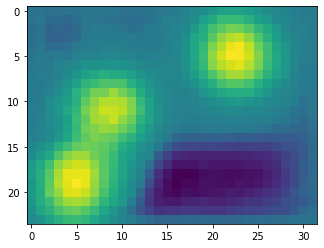

In [5]:
model_path = './models/model_with_batchnorm_no_conv2d'

fp = FrameProcessor(model_path)
raw_frame = np.array([26.30,25.40,24.62,24.32,23.96,24.13,24.02,23.67,23.98,24.12,23.89,23.96,24.26,23.89,24.10,24.15,24.16,23.91,24.30,24.62,24.57,24.73,24.86,24.35,24.54,24.76,25.17,24.54,24.62,24.49,24.64,24.72,24.94,25.28,24.57,25.03,24.21,24.33,23.74,24.34,24.12,24.20,24.01,24.31,24.15,24.42,24.14,24.20,24.32,24.28,24.25,24.69,24.66,25.09,25.00,25.21,24.49,24.95,24.66,24.98,25.36,25.47,24.80,25.06,25.55,25.09,26.00,26.18,24.42,23.54,23.89,23.94,24.17,23.78,24.33,23.90,24.26,24.18,24.32,24.03,24.32,23.96,24.38,24.50,26.70,27.40,27.41,27.27,25.65,25.27,25.30,24.98,25.42,24.89,25.21,25.87,25.52,
                          25.90,26.28,26.04,24.06,24.37,24.00,24.23,23.92,24.04,24.41,24.46,24.30,24.51,24.62,24.35,24.12,24.29,24.15,24.53,28.01,28.55,28.44,28.22,25.69,25.75,25.12,25.37,25.12,25.68,25.49,24.66,26.08,26.11,27.20,25.16,24.86,24.53,24.05,24.05,24.25,24.31,24.10,24.37,24.56,24.24,24.22,24.13,24.48,24.38,24.39,24.77,28.24,28.71,28.54,28.01,26.94,26.82,25.83,25.53,25.25,25.18,25.11,25.25,25.66,26.08,25.53,25.00,24.79,25.03,24.30,24.13,24.43,24.37,24.14,24.36,24.16,24.19,
                          24.25,24.44,24.24,24.25,24.21,24.85,28.01,28.34,28.12,27.89,26.98,28.14,26.41,25.86,25.07,25.78,24.80,25.27,26.23,25.72,24.81,24.51,25.44,24.68,24.74,24.50,24.68,24.29,24.09,24.39,24.23,24.17,24.30,24.32,24.29,24.60,24.40,24.49,26.57,27.82,28.14,27.34,26.90,27.69,26.14,25.33,25.38,25.06,24.48,24.77,26.18,26.82,24.87,24.96,25.49,25.17,24.40,25.13,24.25,25.18,24.17,24.11,24.49,24.18,24.35,24.49,24.33,24.53,24.51,24.74,26.17,27.09,27.33,26.04,26.09,26.34,25.47,25.21,24.75,24.56,24.49,25.30,26.54,26.63,24.94,25.41,25.32,24.74,25.46,25.40,27.16,25.78,26.40,24.17,24.26,24.28,24.38,
                          24.29,24.43,24.62,24.58,24.62,25.09,25.15,25.16,24.91,24.54,24.51,24.49,24.58,24.63,24.68,24.95,24.84,26.81,27.32,25.08,25.07,25.40,25.34,26.05,27.11,27.12,28.91,25.48,26.05,24.26,24.44,24.60,24.49,24.58,24.66,24.62,24.76,24.23,24.54,24.13,24.28,24.50,24.55,24.67,24.48,24.67,24.53,24.29,25.18,26.62,27.28,25.30,25.43,25.79,25.55,26.41,27.44,28.50,29.07,27.70,25.46,24.76,24.37,24.78,24.71,24.71,24.68,24.82,24.42,24.18,23.88,24.17,24.42,24.78,24.77,24.51,
                          24.43,24.75,24.35,25.17,24.62,26.31,27.40,25.72,25.93,25.43,25.42,27.39,27.29,28.52,28.17,26.92,26.39,24.81,24.85,24.49,24.57,24.76,24.69,24.43,24.32,23.96,24.09,24.06,24.61,24.59,24.72,24.72,24.28,24.38,24.40,24.65,25.14,25.81,25.71,25.59,25.74,25.27,25.78,26.65,27.84,27.82,27.98,25.83,25.94,24.86,24.90,24.45,24.64,24.83,24.55,24.52,24.44,24.35,24.32,24.44,24.51,24.78,24.32,24.63,24.85,24.75,24.55,24.79,24.73,25.85,25.57,25.36,25.60,25.39,25.37,26.59,25.84,28.31,27.04,25.86,24.87,24.95,24.89,24.59,24.96,24.70,24.90,24.66,24.62,24.29,24.46,24.55,24.51,24.52,24.57,24.42,24.81,
                          24.63,24.63,24.67,24.87,25.46,25.05,25.19,25.09,25.14,25.17,25.19,25.73,26.17,25.72,25.22,25.33,25.07,24.83,25.12,24.92,25.15,24.74,24.93,24.85,25.22,24.73,24.94,24.65,24.97,24.63,24.85,24.70,24.67,24.77,24.69,25.17,24.88,25.76,25.40,25.35,25.39,25.33,25.68,25.47,25.82,25.54,25.23,25.40,24.99,25.17,25.04,25.26,25.05,25.13,25.17,24.91,24.99,25.36,24.96,25.15,24.90,24.81,24.62,24.97,24.47,25.01,24.54,25.29,26.57,25.80,26.06,25.54,27.46,26.74,25.75,25.52,
                          25.11,25.13,25.28,25.50,25.31,25.43,25.15,25.49,25.30,25.14,24.98,25.01,25.28,25.03,25.04,24.97,25.05,24.93,25.05,24.65,24.69,24.56,25.15,25.40,26.88,26.72,25.88,26.11,27.62,27.41,25.54,25.57,25.48,25.37,25.45,25.44,25.64,25.62,25.62,25.55,25.12,25.32,24.53,24.95,25.11,25.23,25.20,25.19,24.97,24.99,24.98,24.88,24.79,25.04,24.98,25.18,27.10,26.77,26.94,26.84,29.03,28.50,26.17,25.22,25.72,25.36,25.69,25.70,25.62,25.62,26.09,25.74,25.48,25.22,24.93,24.73,
                          24.96,25.17,25.48,25.34,25.40,25.25,24.78,24.93,25.20,24.62,25.33,25.04,26.88,27.34,27.59,28.39,29.27,28.78,25.72,25.85,25.38,25.67,25.49,25.41,25.82,25.75,26.16,25.85,25.45,25.30,24.62,24.80,25.18,25.45,25.04,25.55,24.91,25.39,25.01,24.99,25.17,25.25,24.58,24.80,27.64,27.09,27.18,27.96,27.94,27.12,25.31,25.52,26.18,25.46,25.52,25.65,25.70,25.92,25.98,25.79,25.72,25.17,24.68,25.21,25.81,25.36,25.26,25.17,25.26,24.71,24.90,24.65,25.05,24.69,24.88,24.96,26.91,27.62,27.37,27.54,26.78,26.63,25.92,26.13,25.69,26.03,25.89,25.60,25.45,25.69,25.87,25.65,25.48,25.41,24.58,25.04,25.57,
                          25.62,25.32,24.97,24.99,25.05,24.94,25.18,24.94,25.19,25.00,25.65,27.27,25.84,26.61,26.67,27.08,25.93,25.68,25.48,25.85,25.53,26.04,25.74,26.05,25.46,25.65,25.39,25.72,25.60,25.83,25.77,26.02,26.23,25.12,25.31,25.49,25.31,25.32,25.28,25.29,25.52,25.61,25.92,27.54,27.43,26.99,27.30,26.67,26.24,26.08,26.16,25.60,25.32,25.40,25.58,25.31,25.52,25.60,25.67,25.09,25.38,25.73,26.24,25.78,25.92,25.74,25.94,25.08,25.43,24.95,25.63,25.23,25.43,25.33,25.69])

pf = fp.process_frame(raw_frame)
plt.imshow(pf);

print(fp.get_people_count_on_latest_frame())

In [6]:
frame_2d = np.reshape(raw_frame, IR_CAMERA_RESOLUTION)
frame_normalized = (frame_2d - TEMPERATURE_NORMALIZATION__MIN) * \
                           (1 / (TEMPERATURE_NORMALIZATION__MAX - TEMPERATURE_NORMALIZATION__MIN))
frame_for_model = frame_normalized[np.newaxis, :, :][np.newaxis, :, :, :]
frame_for_model.shape

(1, 1, 24, 32)

# ONNX

## Convert

In [7]:
import torch.onnx

In [8]:
model = AutoEncoder(1, 1)

model.load_state_dict(torch.load(model_path))
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv1): ContractBlock(
      (conv): DoubleConv(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): ContractBlock(
      (conv): DoubleConv(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

In [9]:
# Input to the model
x = torch.randn(1, 1, 24, 32, requires_grad=True)
torch_out = model(x)

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  f"{model_path}.onnx",      # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

/home/mateusz/miniconda3/envs/thermo/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:252: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  warnings.warn("You are trying to export the model with " + onnx_op + " for ONNX opset version "


## Check converted model

In [10]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(f"{model_path}.onnx")

1.418774384718675

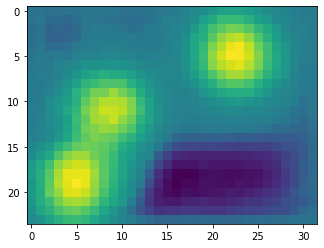

In [11]:
# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: frame_for_model.astype(np.float32)}
ort_outs = ort_session.run(None, ort_inputs)
plt.imshow(ort_outs[0][0])

np.sum(ort_outs) / 52.0

# TensorFlow

## Convert

In [12]:
!onnx-tf convert -i {model_path}.onnx -o {model_path}_tf

2021-12-08 16:59:42.459522: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-08 16:59:43,592 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2021-12-08 16:59:43.607290: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-08 16:59:43.643729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 16:59:43.644123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce MX230 computeCapability: 6.1
coreClock: 1.531GHz coreCount: 2 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 52.21GiB/s
2021-12-08 16:59:43.644155: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic lib

# TensorFlow Lite

In [13]:
import tensorflow as tf

2021-12-08 16:59:51.582752: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [14]:
def inference_tflite(model_path: str, input_data: np.ndarray):
    dtype = np.float32
    
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print(input_details)
    print(output_details)
    
    in_scale = input_details[0]['quantization'][0]
    in_zero_point = input_details[0]['quantization'][1]
    
    if (in_scale, in_zero_point) != (0.0, 0):
        input_data = input_data / in_scale + in_zero_point
        dtype = np.int8
    
    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], input_data.astype(dtype))

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    out_scale = output_details[0]['quantization'][0]
    out_zero_point = output_details[0]['quantization'][1]
    
    if (out_scale, out_zero_point) != (0.0, 0):
        output_data = (output_data - out_zero_point) * out_scale

    print(np.sum(output_data) / 52.0)
    plt.imshow(output_data[0]);

## FP32

2021-12-08 16:59:52.975400: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-08 16:59:53.049407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 16:59:53.049719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce MX230 computeCapability: 6.1
coreClock: 1.531GHz coreCount: 2 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 52.21GiB/s
2021-12-08 16:59:53.049756: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-08 16:59:53.054973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-08 16:59:53.055047: I tensorflow/stream_executor/platform

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([ 1,  1, 24, 32], dtype=int32), 'shape_signature': array([-1,  1, 24, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'PartitionedCall:0', 'index': 138, 'shape': array([ 1, 24, 32], dtype=int32), 'shape_signature': array([-1, 24, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
1.4187748248760517


2021-12-08 16:59:55.392633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-12-08 16:59:55.392658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-12-08 16:59:55.392681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.
2021-12-08 16:59:55.393984: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./models/model_with_batchnorm_no_conv2d_tf
2021-12-08 16:59:55.397274: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-12-08 16:59:55.397303: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./models/model_with_batchnorm_no_conv2d_tf
2021-12-08 16:59:55.397351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-08 16:59:55.397356: I tensorflow/core/

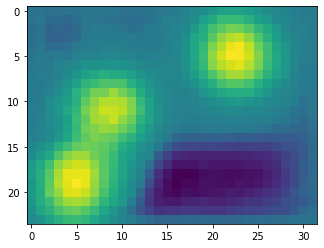

In [15]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(f"{model_path}_tf") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(f"{model_path}_fp32.tflite", 'wb') as f:
    f.write(tflite_model)
    
inference_tflite(f"{model_path}_fp32.tflite", frame_for_model)

## FP16

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([ 1,  1, 24, 32], dtype=int32), 'shape_signature': array([-1,  1, 24, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'PartitionedCall:0', 'index': 138, 'shape': array([ 1, 24, 32], dtype=int32), 'shape_signature': array([-1, 24, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
1.4173751244178185


2021-12-08 16:59:57.288926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-12-08 16:59:57.288951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-12-08 16:59:57.288956: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.
2021-12-08 16:59:57.289225: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./models/model_with_batchnorm_no_conv2d_tf
2021-12-08 16:59:57.292127: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-12-08 16:59:57.292169: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./models/model_with_batchnorm_no_conv2d_tf
2021-12-08 16:59:57.292230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-08 16:59:57.292235: I tensorflow/core/

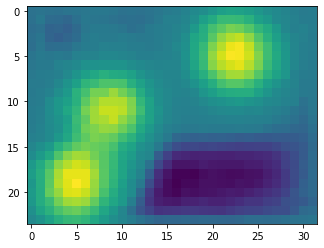

In [16]:
converter = tf.lite.TFLiteConverter.from_saved_model(f"{model_path}_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_fp16 = converter.convert()

# Save the model.
with open(f"{model_path}_fp16.tflite", 'wb') as f:
    f.write(tflite_model_fp16)
    
inference_tflite(f"{model_path}_fp16.tflite", frame_for_model)

## INT8

In [17]:
import pandas as pd

def representative_dataset():
    df = pd.read_csv('../data_processing/example_data/one_person_close.csv', delimiter=',', skiprows=[0], index_col=0)
    
    for i in range(100):
        data = df.iloc[i].values[1:]
        data = np.reshape(data, IR_CAMERA_RESOLUTION)
        data = (data - TEMPERATURE_NORMALIZATION__MIN) * \
                           (1 / (TEMPERATURE_NORMALIZATION__MAX - TEMPERATURE_NORMALIZATION__MIN))
        data = data[np.newaxis, :, :][np.newaxis, :, :, :]
        data = data.astype(np.float32)
        
        yield [data]

### Convert real value data to int8 format 
int8_value = real_value / scale + zero_point

### Convert int8 data to real value format
real_value = (int8_value - zero_point) * scale

2021-12-08 16:59:59.186884: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-12-08 16:59:59.186907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-12-08 16:59:59.186912: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.
2021-12-08 16:59:59.187144: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: ./models/model_with_batchnorm_no_conv2d_tf
2021-12-08 16:59:59.190057: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-12-08 16:59:59.190079: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: ./models/model_with_batchnorm_no_conv2d_tf
2021-12-08 16:59:59.190128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-08 16:59:59.190151: I tensorflow/core/

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([ 1,  1, 24, 32], dtype=int32), 'shape_signature': array([-1,  1, 24, 32], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0037934640422463417, -101), 'quantization_parameters': {'scales': array([0.00379346], dtype=float32), 'zero_points': array([-101], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'PartitionedCall:0', 'index': 138, 'shape': array([ 1, 24, 32], dtype=int32), 'shape_signature': array([-1, 24, 32], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.007720551919192076, -80), 'quantization_parameters': {'scales': array([0.00772055], dtype=float32), 'zero_points': array([-80], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
1.6340845081274613


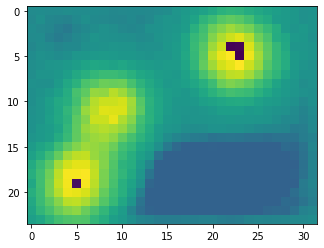

In [18]:
converter = tf.lite.TFLiteConverter.from_saved_model(f"{model_path}_tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
converter._experimental_new_quantizer = True
tflite_model_int8 = converter.convert()

# Save the model.
with open(f"{model_path}_int8.tflite", 'wb') as f:
    f.write(tflite_model_int8)
    
inference_tflite(f"{model_path}_int8.tflite", frame_for_model)

## Edge TPU compiled

In [19]:
!edgetpu_compiler {model_path}_int8.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.
loc(fused["onnx_tf_prefix_BatchNormalization_36/add_11", "transpose_1/perm"]): error: non-broadcastable operands
loc(fused["onnx_tf_prefix_BatchNormalization_27/add_11", "transpose_1/perm"]): error: non-broadcastable operands
loc(fused["onnx_tf_prefix_BatchNormalization_18/add_11", "transpose_1/perm"]): error: non-broadcastable operands
loc(fused["transpose_14", "transpose_1/perm"]): error: non-broadcastable operands
loc(fused["transpose_14", "transpose_1/perm"]): error: non-broadcastable operands
loc(fused["transpose_6", "transpose_1/perm"]): error: non-broadcastable operands
loc(fused["transpose_6", "transpose_1/perm"]): error: non-broadcastable operands
Compilation child process completed within timeout period.
Compilation failed! 


## TensorFlow Lite Micro

In [20]:
!xxd -i {model_path}_int8.tflite {model_path}_int8.cc

In [21]:
!sed -i 's/'{model_path.replace('/', '_').replace('.', '_')}'_int8_tflite/g_model/g' {model_path}_int8.cc

In [22]:
!cat {model_path}_int8.cc | tail

  0x00, 0x11, 0x0a, 0x00, 0x08, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x00,
  0x0a, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff,
  0x12, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x12,
  0xe0, 0xff, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03, 0xf0, 0xff, 0xff, 0xff, 0x27, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x27, 0x0c, 0x00, 0x10, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x22, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x22
};
unsigned int g_model_len = 164232;
